In [1]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=56f04d32a9075d688a49880dbdf2718a56d309d38e80d1e1bca8082ad0050d1f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
pip install pyoselm

  Preparing metadata (setup.py) ... done
Discarding https://files.pythonhosted.org/packages/56/c6/0914a51aea89064725cec9b9ad92adb77d8ae6b03dd369b00641369aae79/pyoselm-1.0.1-2.tar.gz (from https://pypi.org/simple/pyoselm/): Requested pyoselm from https://files.pythonhosted.org/packages/56/c6/0914a51aea89064725cec9b9ad92adb77d8ae6b03dd369b00641369aae79/pyoselm-1.0.1-2.tar.gz has inconsistent version: expected '1.0.1.post2', but metadata has '1.0.1'



📘 X_train_scaled DataFrame:
        BVP       EDA      TEMP      AccX      AccY      AccZ        HR  \
0 -3.637107 -0.640298 -1.000436  1.394057 -0.646130  1.189580 -0.551251   
1  0.179808 -0.658935  0.727069 -0.420363 -1.194035  0.154585  0.276302   
2 -0.210431  0.885215 -0.520573 -0.280793  0.527954  0.622002 -0.306659   
3  0.002711 -0.671679  1.004322 -0.746029  0.606226  0.187972  0.778055   
4  7.028627  1.978133  1.398876 -1.118217 -0.606993 -1.013957  0.036544   

      Delta     Theta    Alpha1    Alpha2     Beta1     Beta2    Gamma1  \
0 -0.543635  2.613001 -0.521736  0.382069 -0.379010 -0.168772  8.611543   
1 -0.445946 -0.545911  0.495684 -0.675699 -0.678930  0.440231 -0.451797   
2 -0.295491 -0.201855 -0.510869 -0.537818 -0.722953  0.909343  0.180146   
3 -0.499958 -0.311743  0.238484  0.314970  4.912600 -0.537903 -0.353875   
4 -0.704435 -0.489852 -0.651057  0.049133  0.844237 -0.027085  0.134743   

     Gamma2   Attention   Meditation  
0 -0.503361   -0.173077     0.

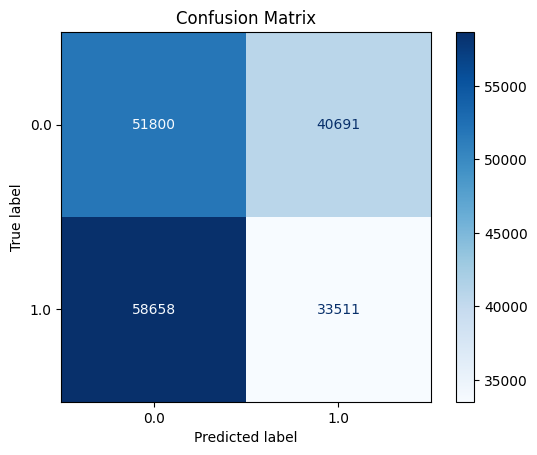

   Sample  Predicted_Class  Uncertainty (1 - max prob)
0       0              1.0                    0.418501
1       1              1.0                    0.054108
2       2              1.0                    0.431655
3       3              0.0                    0.370256
4       4              1.0                    0.228562


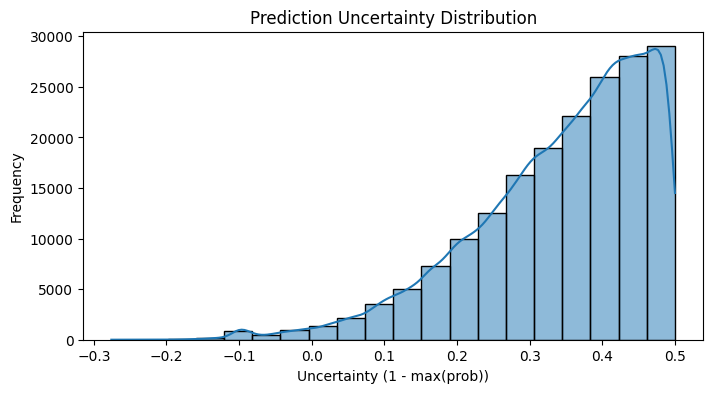

 96%|=================== | 192/200 [00:22<00:00]       

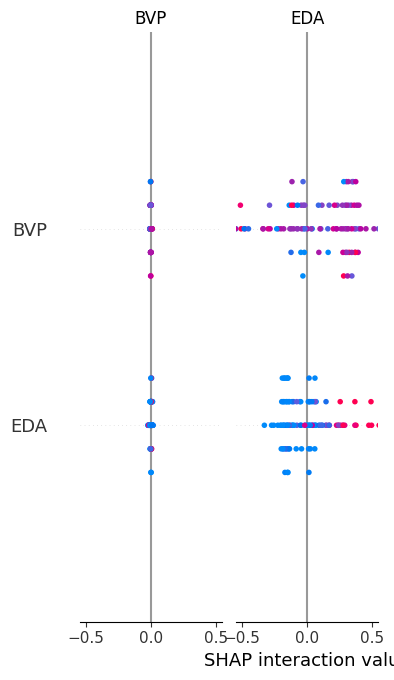


🟡 LIME Explanation for First Sample:
[('TEMP <= -0.46', 0.10197761913293986), ('AccY > 0.49', -0.09729270141039598), ('-0.65 < EDA <= -0.43', -0.0913466093364729), ('0.25 < AccZ <= 0.82', 0.024243975371422172), (' Gamma2 <= -0.63', 0.016401444147587884), ('0.03 < BVP <= 0.33', -0.015265900165050925), ('HR <= -0.69', 0.010931734798921483), (' Meditation > 0.88', 0.009478407600572064), (' Alpha1 <= -0.66', 0.006767473393005432), (' Beta2 <= -0.65', 0.006103642814455698)]

✅ Results saved to 'OSELM_Model_Results.xlsx'


In [5]:
# oselm_uncertainty_xai.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)

from scipy.special import softmax
from scipy.linalg import pinv
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import as_float_array

import warnings
warnings.filterwarnings("ignore")


class SimpleRandomLayer:
    def __init__(self, n_hidden=100, activation_func="sigmoid", random_state=None):
        self.n_hidden = n_hidden
        self.activation_func = activation_func
        self.random_state = np.random.RandomState(random_state)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit_transform(self, X):
        self.input_weights = self.random_state.uniform(-1., 1., (X.shape[1], self.n_hidden))
        self.biases = self.random_state.uniform(-1., 1., (self.n_hidden,))
        H = X @ self.input_weights + self.biases
        return self._sigmoid(H)


class OSELMClassifier:
    def __init__(self, n_hidden=100, activation_func="sigmoid", random_state=0):
        self.n_hidden = n_hidden
        self.activation_func = activation_func
        self.random_state = random_state
        self.layer = SimpleRandomLayer(n_hidden, activation_func, random_state)
        self.binarizer = LabelBinarizer(neg_label=0, pos_label=1)
        self.beta = None
        self.P = None

    def fit(self, X, y):
        y_bin = self.binarizer.fit_transform(y)
        H = self.layer.fit_transform(X)
        self.P = pinv(H.T @ H)
        self.beta = self.P @ H.T @ y_bin
        self.classes_ = self.binarizer.classes_
        return self

    def predict(self, X):
        H = self.layer.fit_transform(X)
        output = H @ self.beta
        # In binary case, output is (n_samples, 1), inverse_transform expects (n_samples,) or (n_samples, n_classes)
        # For inverse_transform, we can pass the raw output, it will map based on which class is "closer"
        return self.binarizer.inverse_transform(output)


    def predict_proba(self, X):
        H = self.layer.fit_transform(X)
        raw_output = H @ self.beta
        if raw_output.shape[1] == 1 and len(self.classes_) == 2:
            # Binary case: predict_proba needs to return probabilities for both classes
            # Assuming raw_output is for the positive class
            prob_positive = raw_output  # This is a simplification; ideally should be sigmoid of raw_output if not already
            prob_negative = 1 - prob_positive
            return np.hstack((prob_negative, prob_positive))
        return softmax(raw_output, axis=1)


def compute_uncertainty(probs):
    return 1 - np.max(probs, axis=1)


def main():
    data = pd.read_csv("/content/drive/MyDrive/CODE/Prince Okyere/MID/MEFAR_MID.csv")
    data.dropna(inplace=True)
    label_encoder = LabelEncoder()
    data['class'] = label_encoder.fit_transform(data['class'])
    classes = label_encoder.classes_.astype(str)

    X = data.drop('class', axis=1)
    y = data['class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    oselm = OSELMClassifier(n_hidden=100, activation_func="sigmoid", random_state=0)
    oselm.fit(X_train_scaled, y_train)
    y_pred_class = oselm.predict(X_test_scaled)
    y_pred_prob = oselm.predict_proba(X_test_scaled)

    # Convert scaled features to DataFrames
    X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

    # Convert predictions to DataFrames
    y_pred_class_df = pd.DataFrame({"Predicted Class": label_encoder.inverse_transform(y_pred_class)})
    y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=[f"Class_{cls}" for cls in label_encoder.classes_])

    # Display DataFrames
    print("\n📘 X_train_scaled DataFrame:")
    print(X_train_df.head())

    print("\n📗 X_test_scaled DataFrame:")
    print(X_test_df.head())

    print("\n📙 Predicted Class DataFrame:")
    print(y_pred_class_df.head())

    print("\n📕 Predicted Probabilities DataFrame:")
    print(y_pred_prob_df.head())


    acc = accuracy_score(y_test, y_pred_class)
    prec = precision_score(y_test, y_pred_class, average='weighted')
    rec = recall_score(y_test, y_pred_class, average='weighted')
    f1 = f1_score(y_test, y_pred_class, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred_class)
    report = classification_report(y_test, y_pred_class, target_names=classes)
    cm = confusion_matrix(y_test, y_pred_class)

    print("\n📊 Classification Report:\n", report)

    youden_index = np.nan
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall_score(y_test, y_pred_class)
        youden_index = sensitivity + specificity - 1

    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    uncertainties = compute_uncertainty(y_pred_prob)
    uncertainty_df = pd.DataFrame({
        "Sample": np.arange(len(uncertainties)),
        "Predicted_Class": label_encoder.inverse_transform(y_pred_class),
        "Uncertainty (1 - max prob)": uncertainties
    })
    print(uncertainty_df.head())

    plt.figure(figsize=(8, 4))
    sns.histplot(uncertainties, bins=20, kde=True)
    plt.title("Prediction Uncertainty Distribution")
    plt.xlabel("Uncertainty (1 - max(prob))")
    plt.ylabel("Frequency")
    plt.show()

    rf = RandomForestClassifier()
    rf.fit(X_train_scaled, y_train)

    explainer = shap.Explainer(rf, X_train_scaled)
    shap_values = explainer(X_test_scaled[:100])
    shap.summary_plot(shap_values, X_test.iloc[:100], show=True)

    lime_exp = LimeTabularExplainer(X_train_scaled, feature_names=X.columns,
                                    class_names=classes, discretize_continuous=True)
    lime_result = lime_exp.explain_instance(X_test_scaled[0], rf.predict_proba, num_features=10)
    print("\n🟡 LIME Explanation for First Sample:")
    print(lime_result.as_list())

    results_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Youden Index"],
        "Value": [acc, prec, rec, f1, mcc, youden_index]
    })
    results_df.to_excel("OSELM_Model_Results.xlsx", index=False)
    print("\n✅ Results saved to 'OSELM_Model_Results.xlsx'")


if __name__ == "__main__":
    main()